# ライブラリのインストール

In [4]:
# !conda create -n my_env python=3.9
# !conda activate my_env
# 依存性の競合が少ない順でインストール
!pip install numpy==1.23.5
!pip install pandas
!pip install dowhy
!pip install econml shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 69.9 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: shap
    Found existing installation: shap 0.47.1
    Uninstalling shap-0.47.1:
      Successfully uninstalled shap-0.47.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires

In [1]:
# 乱数のシードを固定
import random
import numpy as np

random.seed(4963)
np.random.seed(4963)

In [2]:
# 使用するパッケージ（ライブラリと関数）を定義
import pandas as pd

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats

# 標準正規分布の生成用
from numpy.random import randn

# 因果グラフ用
import dowhy
from dowhy import CausalModel

# グラフの描画用
import matplotlib.pyplot as plt
%matplotlib inline

# 回帰分析用
import statsmodels.api as sm

# グラフ描画用
import seaborn as sns
import matplotlib.pyplot as plt

# ダミー変数作成用
from sklearn.preprocessing import OneHotEncoder

# 計算資源を測定
import resource

import os
import time
import pickle
from sklearn.model_selection import train_test_split # 学習データと検証データに分ける関数
from sklearn import metrics # 精度検証に必要な関数
from sklearn.linear_model import LogisticRegression # ロジスティック回帰に必要な関数
from sklearn.preprocessing import StandardScaler # 係数解釈をしやすくするため標準化を行う。標準化のための関数

# ロジスティック回帰
import statsmodels.api as sm

# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# LightGBMモデルを作成
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# 評価指標
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# データの読み込み

In [3]:
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
# pickleファイルの読み込み
df = pd.read_pickle('drive/MyDrive/Colab Notebooks/修士論文関係/df_sample1_processed.pickle')
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,G9,H1,H5,H6,H7,I3,Z6,Z14,A8_1,B7_1
0,10281,00336298,310,20231001,10,20231001,2,F,12518,2023,...,1,1,99,3302,39244,1,1,54,1,0
1,10328,00519529,310,20240201,10,20240201,2,F,19572,2024,...,1,,91,7324,14362,7,25,16,1,0
2,03681,00413033,310,20230701,10,20230701,2,4,8315,2023,...,1,,8,9593,15800,6,25,78,0,0
3,01485,00401643,310,20230901,10,20230901,2,4,5986,2023,...,1,,89,2272,7348,7,25,3,0,0
4,09272,00937836,310,20230901,10,20230901,2,M,5876,2023,...,1,1,20,9821,70845,4,,81,1,0


# B7_1からA8_1への因果効果の割り付け

In [49]:
df['B7_1'].value_counts()

,count
B7_1,
0,298570
1,1430


ATEの設定は以下のとおり/
「0」298,570:0.39%の割合で「1」/
「1」1,430:0.44%の割合で「1」

In [50]:
# ベースライン確率 (B7_1=0 のときの A8_1_adjusted=1 の確率)
baseline_prob = 0.39
df['baseline_prob'] = baseline_prob

# 目標とする ATE
target_ate = 0.05

# 介入群の目標確率
treatment_prob = baseline_prob + target_ate

# 確率が0-1の範囲に収まるように調整
treatment_prob = np.clip(treatment_prob, 0, 1)

# A8_1_adjusted の生成
def generate_a8_1(row):
    if row['B7_1'] == 0:
        return np.random.binomial(1, row['baseline_prob'])
    else:
        return np.random.binomial(1, treatment_prob)

df['A8_1_adjusted'] = df.apply(generate_a8_1, axis=1)

# 生成されたデータのATEを確認
actual_ate = df.groupby('B7_1')['A8_1_adjusted'].mean().diff().iloc[-1]
print(f"目標ATE: {target_ate}")
print(f"生成されたデータのATE: {actual_ate}")

# クロス集計で確認
print(pd.crosstab(df['B7_1'], df['A8_1_adjusted'], normalize='index'))



目標ATE: 0.05
生成されたデータのATE: 0.0637593742292808
A8_1_adjusted         0         1
B7_1                             
0              0.609214  0.390786
1              0.545455  0.454545


# 因果効果を割り付けしない場合

In [36]:
# 割り付けしない場合
# df['A8_1_adjusted'] = df['A8_1']

# データ型の設定

In [51]:
# データ型を調整
df['A5'] = df['A5'].astype(str)
df['A6'] = pd.to_datetime(df['A6'])
df['A7'] = df['A7'].astype(str)
df['B8'] = pd.to_datetime(df['B8'])
df['C3'] = pd.to_datetime(df['C3'])
df['E1'] = df['E1'].astype(str)
df['E3'] = pd.to_datetime(df['E3'])
df['Z6'] = pd.to_numeric(df['Z6'], errors='coerce')
df['B7_1'] = df['B7_1'].astype(str)
df['A8_1_adjusted'] = df['A8_1_adjusted'].astype(str)

# モデルの設定

In [11]:
dowhy.__version__

'0.12'

In [12]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [38]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['G4', 'E1', 'I3', 'H5', 'H1', 'H7', 'E6', 'Z6', 'F1', 'E2', 'G9', 'Z14', 'B7_1',
         'A11', 'C3', 'A8_1_adjusted']
edges = [
    ('G4', 'I3'),
    ('I3', 'H5'),
    ('I3', 'B7_1'),
    ('I3', 'A8_1_adjusted'),
    ('E1', 'I3'),
    ('E1', 'H5'),
    ('E1', 'B7_1'),
    ('H5', 'H1'),
    ('H5', 'H7'),
    ('H5', 'B7_1'),
    ('H5', 'A8_1_adjusted'),
    ('H7', 'B7_1'),
    ('H7', 'A8_1_adjusted'),
    ('H1', 'Z14'),
    ('H1', 'B7_1'),
    ('H1', 'A8_1_adjusted'),
    ('E1', 'Z14'),
    ('E2', 'B7_1'),
    ('E2', 'A8_1_adjusted'),
    ('Z6', 'B7_1'),
    ('Z6', 'A8_1_adjusted'),
    ('G9', 'B7_1'),
    ('G9', 'A8_1_adjusted'),
    ('F1', 'B7_1'),
    ('F1', 'A8_1_adjusted'),
    ('Z14', 'B7_1'),
    ('Z14', 'A8_1_adjusted'),
    ('B7_1', 'C3'),
    ('B7_1', 'A8_1_adjusted'),
    ('C3', 'A8_1_adjusted'),
    ('E1', 'A8_1_adjusted'),
    ('Z14', 'A11'),
    ('A11', 'A8_1_adjusted')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += ']'

In [39]:
# Instantiate the CausalModel
model = CausalModel(
    data=df,
    treatment='B7_1',
    outcome='A8_1_adjusted',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

/usr/local/lib/python3.11/dist-packages/dowhy/causal_model.py:583: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


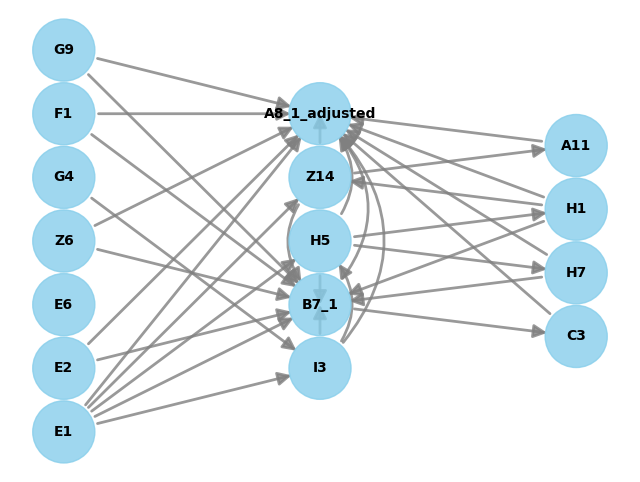

In [40]:
model.view_model()

In [41]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                     
───────(E[A_8_1_adjusted|E1,E2,I3,H1,Z6,H5,Z14,F1,G9,H7])
d[B₇ ₁]                                                  
Estimand assumption 1, Unconfoundedness: If U→{B7_1} and U→A8_1_adjusted then P(A8_1_adjusted|B7_1,E1,E2,I3,H1,Z6,H5,Z14,F1,G9,H7,U) = P(A8_1_adjusted|B7_1,E1,E2,I3,H1,Z6,H5,Z14,F1,G9,H7)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [42]:
adjustment_set = ['E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']

因果グラフから、上記の７つを変数に指定する

# 順序尺度は連続変数、名義尺度はダミー変数に置換した場合

In [52]:
# E1をカテゴリに分割する

_df = df.copy()
_df['E1'] =  _df['E1'].astype(int)
conditions = [
    _df['E1'] <= 100,
    (_df['E1'] > 100) & (_df['E1'] <= 300),
    (_df['E1'] > 300) & (_df['E1'] <= 500),
    (_df['E1'] > 500) & (_df['E1'] <= 700),
    (_df['E1'] > 700) & (_df['E1'] <= 800),
    (_df['E1'] > 800) & (_df['E1'] <= 900),
    (_df['E1'] > 900) & (_df['E1'] <= 1000),
    (_df['E1'] > 1000) & (_df['E1'] <= 1100),
    (_df['E1'] > 1100) & (_df['E1'] <= 1200),
    (_df['E1'] > 1200) & (_df['E1'] <= 1300),
    (_df['E1'] > 1300) & (_df['E1'] <= 1400),
    _df['E1'] >= 1401
]

choices = [
    'A',
    'B',
    'C',
    'D',
    'E',
    'F',
    'G',
    'H',
    'I',
    'J',
    'K',
    'L'
]

# np.select を使用してカテゴリを作成
_df['E1'] = np.select(conditions, choices, default='Unknown')

# カテゴリごとの件数を確認
print(_df['E1'].value_counts().sort_index())

E1
A      115
B     1035
C     5718
D    20720
E    20373
F    28185
G    34948
H    39394
I    39231
J    34788
K    28172
L    47321
Name: count, dtype: int64


In [53]:
# 説明変数の選択
X = _df[['E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14', 'B7_1']]  # 説明変数

# 空欄を0に置換
X = X.replace({'E2': {'': '0'}, 'F1': {'':'0'}, 'I3': {'':'0'}, 'Z6': {'':'0'}}) # 複数の値を置換

# 名義尺度をダミー変数に変更
# 説明変数とする列のリスト
categorical_cols = ['B7_1', 'E2', 'F1', 'I3', 'G9', 'E1']
_X = _df[categorical_cols].copy() # 元のDataFrameを直接変更しないようにコピー
# OneHotEncoderを初期化
encoder = OneHotEncoder(sparse_output=False, drop='first')
# 指定した列をOne-Hotエンコーディング
encoded_cols = encoder.fit_transform(_X[categorical_cols])
# エンコードされた列の名前を取得
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
# エンコードされたデータを新しいデータフレームに変換
encoded_df = pd.DataFrame(encoded_cols, index=_X.index, columns=encoded_feature_names)
# 元のデータフレームからカテゴリカルな列を削除し、エンコードされたデータフレームと結合
X_processed = pd.concat([_X.drop(columns=categorical_cols), encoded_df], axis=1)


# 順序尺度を連続変数に変更
ordinal_scale = _df[['Z6', 'Z14']]
# ordinal_scale['E1'] = pd.to_numeric(_df['E1'], errors='coerce')
ordinal_scale['Z6'] = pd.to_numeric(_df['Z6'], errors='coerce')
ordinal_scale['Z14'] = pd.to_numeric(_df['Z14'], errors='coerce')

# 日付型を連続変数に変換
# datetime_cols = _df[['E3']]
# datetime_cols['year'] = pd.to_datetime(datetime_cols['E3']).dt.year
# datetime_cols['month'] = pd.to_datetime(datetime_cols['E3']).dt.month

X = pd.concat([X_processed, ordinal_scale], axis=1) # datetime_cols[['year', 'month']]

# 欠損値の補完
X.fillna(0, inplace=True)

<ipython-input-53-8f9ab6c0940b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal_scale['Z6'] = pd.to_numeric(_df['Z6'], errors='coerce')
<ipython-input-53-8f9ab6c0940b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal_scale['Z14'] = pd.to_numeric(_df['Z14'], errors='coerce')


In [54]:
def train_model(X, Y, model):
    '''モデルの学習と学習時間の計測

    Args:
            X(DataFrame): 説明変数
            Y(np.ndarray): 目的変数
            model:学習させるモデル

    Returns:
            model: 学習済みのモデル
            elapsed_time:学習時間(単位:秒)
    '''
    # 学習、学習時間を計測
    start = time.time()
    model = model.fit(X, Y)
    elapsed_time = time.time() - start

    # 学習時間の表示
    print('学習時間(単位：秒): \n', elapsed_time)

    return model, elapsed_time

In [55]:
X = sm.add_constant(X)  # 定数項を追加
Y = df['A8_1_adjusted']  # 目的変数
Y = pd.to_numeric(df['A8_1_adjusted'], errors='coerce')

# 学習データの標準化
#sc = StandardScaler()
#X = sc.fit_transform(X)
#Y = sc.transform(Y)

In [56]:
start_cpu = resource.getrusage(resource.RUSAGE_SELF).ru_utime  # 開始時のCPU時間
# X = sm.add_constant(X['B7_1_1'])  # 定数項を追加
X = sm.add_constant(X)  # 定数項を追加
Y = df['A8_1_adjusted']  # 目的変数
Y = pd.to_numeric(df['A8_1_adjusted'], errors='coerce')

model = sm.Logit(Y, X).fit()  # モデルの適合

end_cpu = resource.getrusage(resource.RUSAGE_SELF).ru_utime  # 終了時のCPU時間
elapsed_cpu = end_cpu - start_cpu  # 経過CPU時間

print(model.summary())  # 結果の表示

max_memory = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss  # 最大メモリ使用量
print(f"reg のCPU時間: {elapsed_cpu:.4f} 秒, 最大メモリ使用量: {max_memory} KB")
print(model.summary())  # 結果の表示

Optimization terminated successfully.
         Current function value: 0.669158
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          A8_1_adjusted   No. Observations:               300000
Model:                          Logit   Df Residuals:                   299971
Method:                           MLE   Df Model:                           28
Date:                Mon, 14 Apr 2025   Pseudo R-squ.:               0.0001120
Time:                        07:40:42   Log-Likelihood:            -2.0075e+05
converged:                       True   LL-Null:                   -2.0077e+05
Covariance Type:            nonrobust   LLR p-value:                   0.02216
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4347      0.193     -2.247      0.025      -0.814      -0.056
B7_1_1         0.2620      0.

# データの作成

In [63]:
# num_data = 3000000
num_data = 300000

# A1
categories_a1 = [
    ('01000', '01999'), ('02000', '02999'), ('03000', '03999'),
    ('04000', '04999'), ('05000', '05999'), ('06000', '06999'),
    ('07000', '07999'), ('08000', '08999'), ('09000', '09999'),
    ('10000', '10999'), ('11000', '11999'), ('12000', '12999')
]
probabilities_a1 = [0.4, 0.19, 0.12, 0.07, 0.06, 0.12, 0.02, 0.03, 0.02, 0.04, 0.03, 0.01] #割合の合計は1

def generate_random_strings(categories_a1, probabilities_a1, total_count):
    """カテゴリごとに指定された割合でランダムな文字列を生成する。

    Args:
        categories (list): カテゴリのリスト (例: [('01000', '01999'), ...])
        probabilities (list): 各カテゴリの割合のリスト
        total_count (int): 生成する文字列の総数

    Returns:
        pd.Series: ランダムな文字列のSeries
    """

    category_counts = (np.array(probabilities_a1) * total_count).astype(int)
    remaining = total_count - sum(category_counts)
    category_counts[0] += remaining  # 誤差調整

    result = []
    for (start, end), count in zip(categories_a1, category_counts):
        start_int = int(start)
        end_int = int(end)
        random_ints = np.random.randint(start_int, end_int + 1, count)
        random_strings = [f"{i:05d}" for i in random_ints]
        result.extend(random_strings)

    np.random.shuffle(result)  # 結果をシャッフル
    return pd.Series(result)

total_count = num_data  # 生成する文字列の総数

# A2
def generate_random_8digit_strings(num_strings):
    """8桁のランダムな文字列を生成する。

    Args:
        num_strings (int): 生成する文字列の数

    Returns:
        list: 生成された文字列のリスト
    """
    random_ints = np.random.randint(0, 1000000, num_strings)
    random_strings = [f"{i:08d}" for i in random_ints]
    return random_strings

# A3
def assign_3digit_strings(num_strings, probabilities):
    """3桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['010', '310']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_a3 = [0.05, 0.95]  # '010'が5%, '310'が95%

# A4
def assign_8digit_strings(num_strings, probabilities):
    """8桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['20230401','20230501','20230601','20230701','20230801','20230901','20231001','20231101','20231201',
               '20240101','20240201','20240301']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_a4 = [0.08,0.08,0.08,0.1,0.08,0.08,0.08,0.08,0.08,0.1,0.08,0.08]

# A8
def assign_1digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','2','3','4','5','7','8','9','C','D','E','F','G','H','I','J','M','K']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_a8 = [0.00,0.00,0.019,0.540,0.00,0.121,0.00,0.00,0.00,0.00,0.00,0.157,0.00,0.040,0.084,0.02,0.008,0.011] # 令和５年度の納付手段別納付件数

# A11
def assign_8_1digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['01000000','02000000','03000000','04000000','05000000','06000000','07000000','08000000','09000000','10000000','11000000']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_a11 = [0.365,0.316,0.000,0.000,0.00,0.073,0.00,0.064,0.015,0.167,0.00] # 全銀協アンケート（2009）

e_a1 = generate_random_strings(categories_a1, probabilities_a1, total_count)
e_a2 = generate_random_8digit_strings(num_data)
e_a3 = assign_3digit_strings(num_data, probabilities_a3)
e_a4 = assign_8digit_strings(num_data, probabilities_a4)
e_a5 = 10
e_a6 = e_a4
e_a7 = 2
e_a8 = assign_1digit_strings(num_data, probabilities_a8)
e_a9 = np.random.randint(1, 21000, num_data)
e_a10 = e_a4.str[:4]
e_a11 = assign_8_1digit_strings(num_data, probabilities_a11)

In [64]:
# B7
def assign_1_b_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','2','3','4','5','6','9','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_b7 = [0.004,0.0006,0.0002,0.00001,0.000,0.000,0.00001,0.99518] # 局のデータの割合

# B8
def assign_8_b_digit_strings(num_strings, probabilities):
    """8桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['20230401','20230501','20230601','20230701','20230801','20230901','20231001','20231101','20231201',
               '20240101','20240201','20240301','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_b8 = [0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.01,0.00,0.00,0.00,0.00,0.95]

# B9
def assign_1_b9_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','2','4','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_b9 = [0.0028,0.0022,0.00000,0.995] # 局のデータの割合

e_b7 = assign_1_b_digit_strings(num_data, probabilities_b7)
e_b8 = assign_8_b_digit_strings(num_data, probabilities_b8)
e_b9 = assign_1_b9_digit_strings(num_data, probabilities_b9)

In [65]:
# C1
def assign_8_c_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['01000000','02000000','03000000','04000000','05000000','06000000','07000000','08000000','09000000','10000000','11000000','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_c1 = [0.01314,0.011376,0.000,0.000,0.00,0.000,0.00,0.000,0.000,0.006,0.00,0.969484] # 全銀協アンケート（2009）

# C3
def assign_8_c3_digit_strings(num_strings, probabilities):
    """8桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['20010101','20241101','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_c3 = [0.03,0.006,0.964]


e_c1 = assign_8_c_digit_strings(num_data, probabilities_c1)
e_c3 = assign_8_c3_digit_strings(num_data, probabilities_c3)

In [66]:
# E2
def assign_1_e2_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','2','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_e2 = [0.8,0.15,0.05] # 感覚で記載

# E3
def assign_8_e3_digit_strings(num_strings, probabilities):
    """8桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['20010101','20241101','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_e3 = [0.6,0.1,0.3] # 感覚で記載

e_e1 = np.random.normal(loc=1100, scale=300, size=num_data) # 日本産業分類の産業数は約2,100種類
e_e1 = e_e1.astype(int)
e_e2 = assign_1_e2_digit_strings(num_data, probabilities_e2)
e_e3 = assign_8_e3_digit_strings(num_data, probabilities_e3)
e_e4 = np.random.randint(1, 21000, num_data) # 感覚で記載

In [67]:
# F1
def assign_1_f1_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_f1 = [0.85,0.15] # 感覚で記載

# G9
def assign_1_g9_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['0','1','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_g9 = [0.05,0.9,0.05] # 感覚で記載

e_f1 = assign_1_f1_digit_strings(num_data, probabilities_f1)
e_g4 = np.random.randint(1, 21000, num_data) # 感覚で記載
e_g5 = np.random.randint(1, 10500, num_data) # 感覚で記載
e_g6 = np.random.randint(1, 2100, num_data) # 感覚で記載
e_g7 = np.random.randint(1, 1050, num_data) # 感覚で記載
e_g8 = np.random.randint(1, 1050, num_data) # 感覚で記載
e_g9 = assign_1_g9_digit_strings(num_data, probabilities_g9)

In [68]:
# H1
def assign_1_h1_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','2','3','4','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_h1 = [0.2,0.005,0.005,0.005,0.785] # 感覚で記載

# I3
def assign_1_i3_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','2','3','4','5','6','7','8','9','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_i3 = [0.05,0.1,0.1,0.1,0.2,0.1,0.1,0.1,0.1,0.05] # 感覚で記載

# Z6
def assign_2_z6_digit_strings(num_strings, probabilities):
    """2桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['25','1','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_z6 = [0.6,0.1,0.3] # 感覚で記載

e_h1 = assign_1_h1_digit_strings(num_data, probabilities_h1)
e_h5 = np.random.randint(1, 100, num_data) # 感覚で記載
e_h6 = np.random.randint(1, 10000, num_data) # 感覚で記載
e_h7 = np.random.randint(1, 90000, num_data) # 感覚で記載
e_i3 = assign_1_i3_digit_strings(num_data, probabilities_i3)
e_z6 = assign_2_z6_digit_strings(num_data, probabilities_z6)
e_z14 = np.random.randint(1, 100, num_data) # 感覚で記載

In [69]:
a1 = e_a1
a2 = e_a2
a3 = e_a3
a4 = e_a4
a5 = e_a5
a6 = e_a6
a7 = e_a7
a8 = e_a8
a9 = e_a9
a10 = e_a10
a11 = e_a11
b7 = e_b7
b8 = e_b8
b9 = e_b9
c1 = e_c1
c3 = e_c3
e1 = e_e1
e2 = e_e2
e3 = e_e3
e4 = e_e4
f1 = e_f1
g4 = e_g4
g5 = e_g5
g6 = e_g6
g7 = e_g7
g8 = e_g8
g9 = e_g9
h1 = e_h1
h5 = e_h5
h6 = e_h6
h7 = e_h7
i3 = e_i3
z6 = e_z6
z14 = e_z14

In [70]:
# データフレームに格納
df = pd.DataFrame({
    'A1': a1, 'A2': a2, 'A3': a3, 'A4': a4, 'A5': a5, 'A6': a6, 'A7': a7, 'A8': a8, 'A9': a9, 'A10': a10, 'A11': a11,
    'B7': b7, 'B8': b8, 'B9': b9, 'C1': c1, 'C3': c3, 'E1': e1, 'E2': e2, 'E3': e3, 'E4': e4, 'F1': f1, 'G4': g4, 'G5': g5,
    'G6': g6, 'G7': g7, 'G8': g8, 'G9': g9, 'H1': h1, 'H5': h5, 'H6': h6, 'H7': h7, 'I3': i3, 'Z6': z6, 'Z14': z14
})

In [71]:
# pickleファイルに出力
df.to_pickle('df_sample1.pickle')

# データの確認

In [72]:
# データサイズを表示する
df.shape

(300000, 34)

In [73]:
# カラム・インデックスを表示する
print(df.columns)
print(df.index)

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'B7', 'B8', 'B9', 'C1', 'C3', 'E1', 'E2', 'E3', 'E4', 'F1', 'G4', 'G5',
       'G6', 'G7', 'G8', 'G9', 'H1', 'H5', 'H6', 'H7', 'I3', 'Z6', 'Z14'],
      dtype='object')
RangeIndex(start=0, stop=300000, step=1)


In [74]:
df.dtypes

,0
A1,object
A2,object
A3,object
A4,object
A5,int64
A6,object
A7,int64
A8,object
A9,int64
A10,object


In [75]:
# データのメタ情報（型や欠損）を表示する。
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 34 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   A1      300000 non-null  object
 1   A2      300000 non-null  object
 2   A3      300000 non-null  object
 3   A4      300000 non-null  object
 4   A5      300000 non-null  int64 
 5   A6      300000 non-null  object
 6   A7      300000 non-null  int64 
 7   A8      300000 non-null  object
 8   A9      300000 non-null  int64 
 9   A10     300000 non-null  object
 10  A11     300000 non-null  object
 11  B7      300000 non-null  object
 12  B8      300000 non-null  object
 13  B9      300000 non-null  object
 14  C1      300000 non-null  object
 15  C3      300000 non-null  object
 16  E1      300000 non-null  int64 
 17  E2      300000 non-null  object
 18  E3      300000 non-null  object
 19  E4      300000 non-null  int64 
 20  F1      300000 non-null  object
 21  G4      300000 non-null  int64 
 

In [76]:
# 欠損値の有無を確認する
df.isnull().any()

,0
A1,False
A2,False
A3,False
A4,False
A5,False
A6,False
A7,False
A8,False
A9,False
A10,False


In [77]:
# データのサマリを表示する(小数第2位まで表示)。
df.describe().round(2)

,A5,A7,A9,E1,E4,G4,G5,G6,G7,G8,H5,H6,H7,Z14
count,300000.0,300000.0,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00
mean,10.0,2.0,10488.56,1099.47,10482.38,10496.15,5239.39,1048.62,524.38,524.57,49.98,4991.47,44976.83,49.98
std,0.0,0.0,6067.89,300.27,6061.58,6056.39,3030.70,605.92,302.57,302.64,28.58,2882.18,25988.58,28.59
min,10.0,2.0,1.00,-435.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,10.0,2.0,5223.75,897.00,5241.00,5259.00,2616.00,524.00,262.00,263.00,25.00,2493.00,22474.00,25.00
50%,10.0,2.0,10489.00,1099.00,10461.00,10496.00,5234.00,1048.00,524.00,524.00,50.00,4985.00,44999.50,50.00
75%,10.0,2.0,15743.00,1302.00,15737.00,15735.00,7860.00,1574.00,787.00,787.00,75.00,7484.00,67506.00,75.00
max,10.0,2.0,20999.00,2566.00,20999.00,20999.00,10499.00,2099.00,1049.00,1049.00,99.00,9999.00,89999.00,99.00


# 可視化

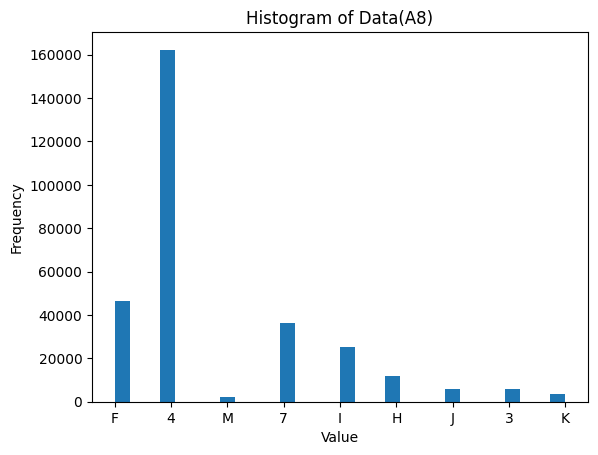

In [78]:
# 目的変数の可視化
plt.hist(df['A8'], bins=30)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Data(A8)")
plt.show()

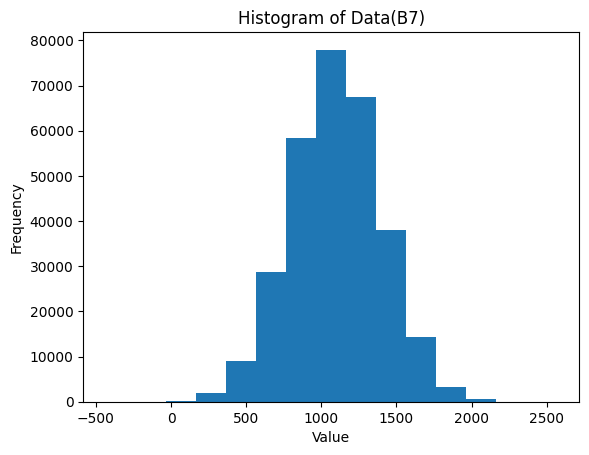

In [79]:
# 説明変数の可視化
plt.hist(df['E1'], bins=15)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Data(B7)")
plt.show()

# 目的変数の加工

In [80]:
# キャッシュレス納付の「7,F,I,J,M」を「1」,それ以外を「0」にする
df['A8_1'] = df['A8'].apply(lambda x: 1 if x in ['7', 'F', 'I', 'J', 'M'] else 0)

In [81]:
# 割合の確認
a = df[df['A8_1']==1]
b = df[df['A8_1']==0]
print('キャッシュレス納付の割合:',len(a)/len(df))
print('窓口納付の割合:',len(b)/len(df))

キャッシュレス納付の割合: 0.38873
窓口納付の割合: 0.61127


# 説明変数の加工

In [82]:
# 利用勧奨ありの「1,2,3,4,5,6,9」を「1」,それ以外を「0」にする
df['B7_1'] = df['B7'].apply(lambda x: 1 if x in ['1', '2', '3', '4', '5', '6', '9'] else 0)

In [83]:
df_1 = df[df['B7_1']==1]
print('利用勧奨ありの件数:',len(df_1))

利用勧奨ありの件数: 1430


# データの出力

In [84]:
# データの出力
df.to_pickle('df_sample1_processed.pickle')